# Домашнее задание: реализация модели latent diffusion

## Интро
На семинарах мы познакомились с тем, как обучать диффузионную модель. Эти модели были реализованы через пиксельную диффузию, которую на практике уже никто не использует, потому что это вычислительно сложно обучить. На семинарах было разобрано обучение диффузионной модели. Для обучения вам предлагается обучение модели на датасете `nelorth/oxford-flowers` (https://huggingface.co/datasets/nelorth/oxford-flowers)  

## Цель домашнего задания
Научиться реализовать модель диффузии, модель скрытой диффузии и вносить в нее модификации.


- Часть 1.2 ДЗ 
- Часть 2 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P2_HW_Stable_diff_finetune.ipynb)
- Часть 3 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P3_HW1_Schedulers_inference_steps_comparison.ipynb)



### [5 баллов] Реализация обучения диффузионной модели на новом датасете

В этой части задания вам рекомендуется взять код с семинара и адаптировать его под обучение на новом датасете.

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели и код обучения модели.


# План решения

В качестве 1-го шага я попробую построить модель "вручную" без использования API библиотеки Hugging Face.

В качестве основы возьму код из следующих источников:

- https://huggingface.co/blog/annotated-diffusion
- https://www.youtube.com/watch?v=a4Yfz2FxXiY&list=WL&index=6

## 1. Подгрузим и преобразуем датасет

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datasets import load_dataset
raw_datasets = load_dataset("nelorth/oxford-flowers")

Found cached dataset parquet (C:/Users/Kate/.cache/huggingface/datasets/nelorth___parquet/nelorth--oxford-flowers-1e451494c03d0040/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7169
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1020
    })
})

In [4]:
from datasets import concatenate_datasets
dataset = concatenate_datasets([raw_datasets['train'], raw_datasets['test']])
dataset = dataset.remove_columns('label')
dataset

Dataset({
    features: ['image'],
    num_rows: 8189
})

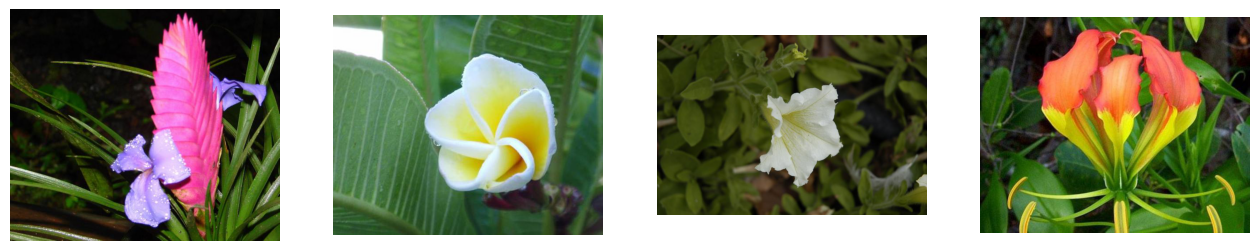

In [5]:
import random
import matplotlib.pyplot as plt

num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_index = random.choice(range(dataset.shape[0]))
    axs[i].imshow(dataset['image'][random_index])
    axs[i].set_axis_off()
#fig.show()

Основные преобразования в датасете в рамках создания класса Dataset:

- Изменение размера изображения
- Поворот изоражения по горизонтали
- Перевод в тензоры
- Создание DataLoader


In [6]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Lambda(lambda t: (t * 2) - 1)  
]
data_transform = transforms.Compose(data_transforms)

In [7]:
def transform(examples):
    images = [data_transform(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

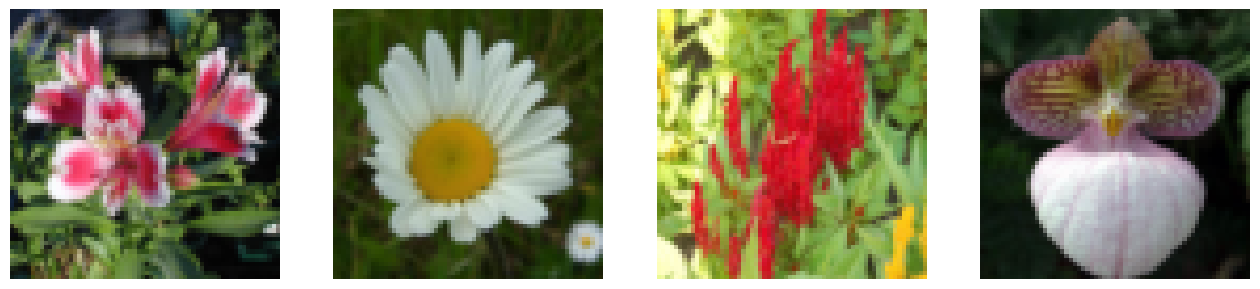

In [8]:
num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_index = random.choice(range(dataset.shape[0]))
    axs[i].imshow(dataset[random_index]['images'].permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()


In [9]:
import torch
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                         shuffle=True, drop_last = True)

## 2. Сравнение методов внесения шума

Нижепредставленные функции для добавления шума были предложены в коде на https://huggingface.co/blog/annotated-diffusion

Посмотрим на графике, как каждая из них "переводит" изображение в шум по мере продвижения по t.

In [10]:
import torch.nn.functional as F

# Code from https://huggingface.co/blog/annotated-diffusion

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

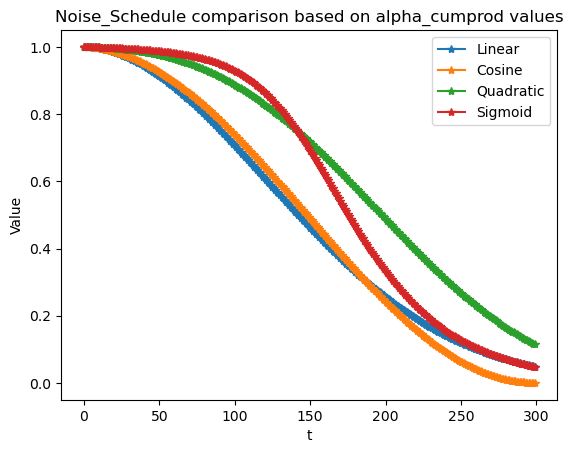

In [11]:
TIME_STEPS = 300
def plot_schedule(schedule_function, label):

    betas = schedule_function(TIME_STEPS)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    t = range(len(alphas))
    plt.plot(t, alphas_cumprod, marker = '*', label = label)

plot_schedule(linear_beta_schedule, label = 'Linear')
plot_schedule(cosine_beta_schedule, label = 'Cosine')
plot_schedule(quadratic_beta_schedule, label = 'Quadratic')
plot_schedule(sigmoid_beta_schedule, label = 'Sigmoid')

plt.xlabel('t')
plt.ylabel('Value')
plt.title('Noise_Schedule comparison based on alpha_cumprod values')
plt.legend()
plt.show()

In [12]:
sample_image = next(iter(dataloader))
sample_image['images'].shape

torch.Size([128, 3, 64, 64])

In [13]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
        
    plt.imshow(reverse_transforms(image))

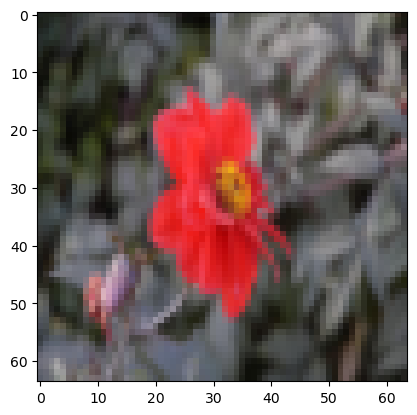

In [14]:
show_tensor_image(sample_image['images'].squeeze())

## 3. Forward Process

Для описания процесса добавления шума рассчитаем данные для формулы:

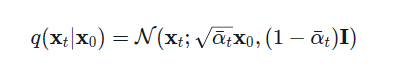

Далее подготовлю функцию, которая отрисует процесс добавления шума при разных выбранных scheduler на 10 шагах. В конце немного видоизменю функцию добавления шума, чтобы ее использовать для обучения.

In [15]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [16]:
def forward_diffuse_process(x_0, t, beta_schedule_function, device = 'cpu'):
    '''
    return diffused image with given x_0 and timestep
    '''
    # precalculations
    betas = beta_schedule_function(TIME_STEPS)
    alphas = 1-betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_oneminus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    
    
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_oneminus_alphas_cumprod_t = get_index_from_list(
        sqrt_oneminus_alphas_cumprod, t, x_0.shape
    )
    
    noise = torch.randn_like(x_0) 
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]
    sqrt_oneminus_alphas_cumprod_t = sqrt_oneminus_alphas_cumprod[t]
    
    
    return sqrt_alphas_cumprod_t.to(device)*x_0.to(device)\
        + sqrt_oneminus_alphas_cumprod_t.to(device)*noise.to(device), noise.to(device)

linear_beta_schedule


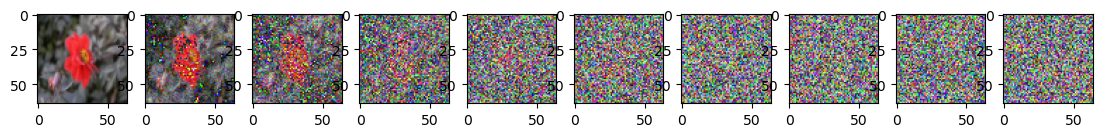

cosine_beta_schedule


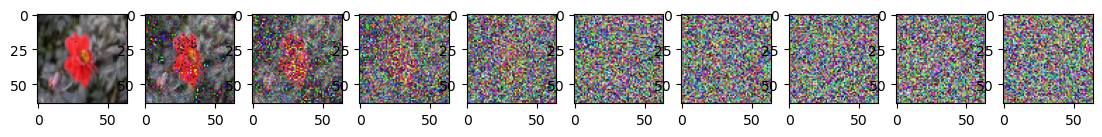

quadratic_beta_schedule


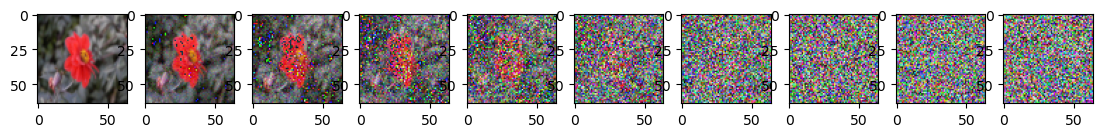

sigmoid_beta_schedule


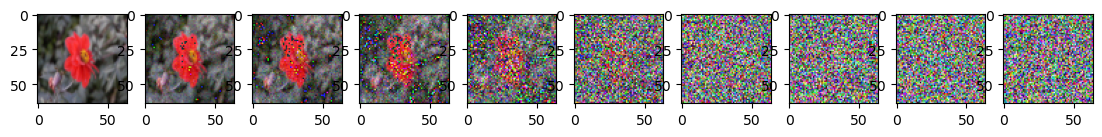

In [17]:
def show_process(beta_schedule_function):
    '''
    return diffused pictures of image with given x_0 and timestep
    '''
    num_images = 10
    stepsize = int(TIME_STEPS/num_images)

    plt.figure(figsize=(15,15))
    for idx in range(0, TIME_STEPS, stepsize):
        image = sample_image['images'][0] #dataset[0]['images']
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(2, num_images+1, int(idx/stepsize) + 1)
        image, noise = forward_diffuse_process(image, t, beta_schedule_function)
        show_tensor_image(image)
    plt.show()
    
print('linear_beta_schedule')
show_process(linear_beta_schedule)

print('cosine_beta_schedule')
show_process(cosine_beta_schedule)

print('quadratic_beta_schedule')
show_process(quadratic_beta_schedule)

print('sigmoid_beta_schedule')
show_process(sigmoid_beta_schedule)

In [18]:
def forward_diffuse_process(x_0, t,device):
    '''
    return diffused image with given x_0 and timestep
    '''
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_oneminus_alphas_cumprod_t = get_index_from_list(
        sqrt_oneminus_alphas_cumprod, t, x_0.shape
    )
    
    noise = torch.randn_like(x_0) 
   
    return sqrt_alphas_cumprod_t.to(device)*x_0.to(device)\
        + sqrt_oneminus_alphas_cumprod_t.to(device)*noise.to(device), noise.to(device)

In [19]:
# Define beta schedule

betas = cosine_beta_schedule(timesteps=TIME_STEPS)

# Pre-calculate different terms for the chosen schudele
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_oneminus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


## 4. Создание сети для предсказания шума

В сеть будеь входить несколько блоков:

1. Позиционные эмбединги для определения timestep
2. Блок для up- и down-sampling

Я не буду создавать дополнительные слои внимания и тд. в сети, интересно сделать ее максимально простой, чтобы я могла протестировать ее на совем GPU и мне просто так легче ознакомиться с ее структурой.

В итоге сеть получает на вход зашумленное изображение, а предсказывает шум на этом изображении. Не буду приводить формулы, пока в них еще не совсем разобралась.

3. Зададим функцию для Loss - разница между фактическим и предсказанным шумом.


In [20]:
from torch import nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
       
        return embeddings

In [21]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [22]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [23]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffuse_process(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

Определим функции для промежуточной генерации на конкретной стадии обучения. Бдует также функция, которая отристует процесс "очищения" кратинки от шума - т.е. сам процесс генерации.

In [24]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_oneminus_alphas_cumprod_t = get_index_from_list(
        sqrt_oneminus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_oneminus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(TIME_STEPS/num_images)

    for i in range(0,TIME_STEPS)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()  

## 5. Обучение

Запустим обучение на 200 эпох и будем генерировать валидационные данные каждые 40 эпох на 0 шаге.

  0%|          | 0/201 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 0.8102273941040039 


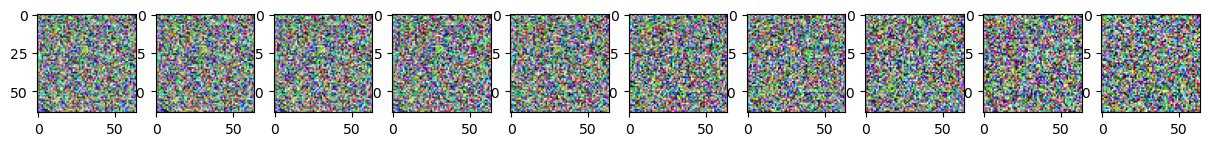

Epoch 40 | step 000 Loss: 0.18880027532577515 


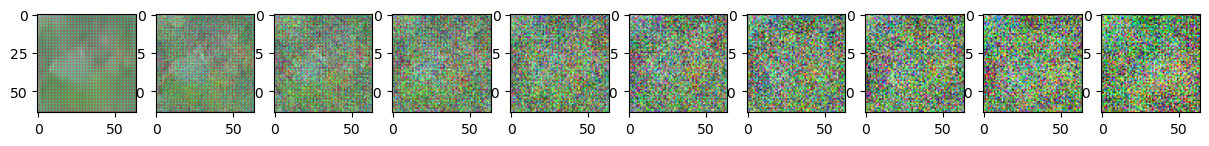

Epoch 80 | step 000 Loss: 0.15900515019893646 


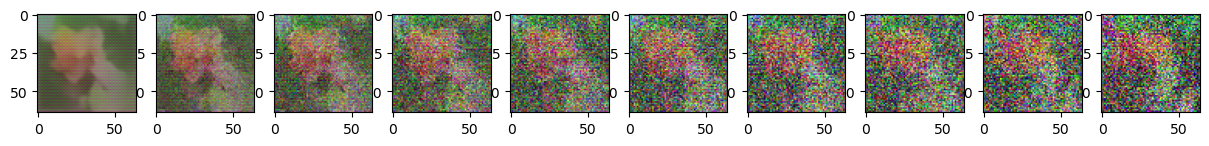

Epoch 120 | step 000 Loss: 0.1618412286043167 


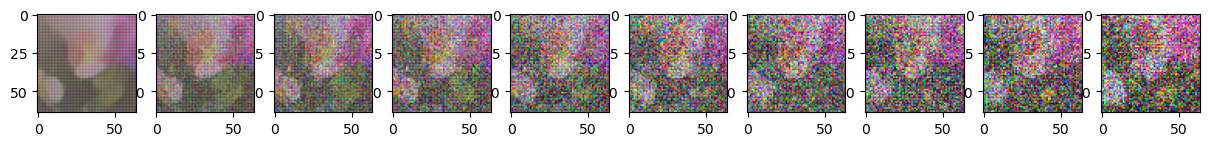

Epoch 160 | step 000 Loss: 0.14850299060344696 


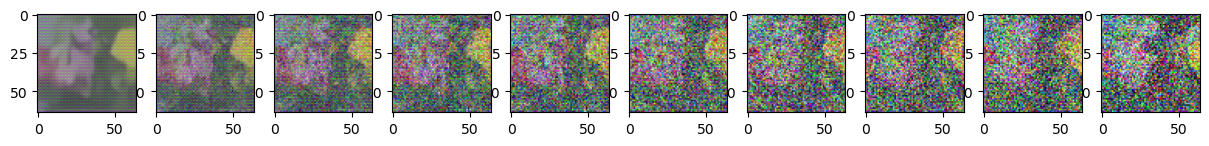

Epoch 200 | step 000 Loss: 0.14664249122142792 


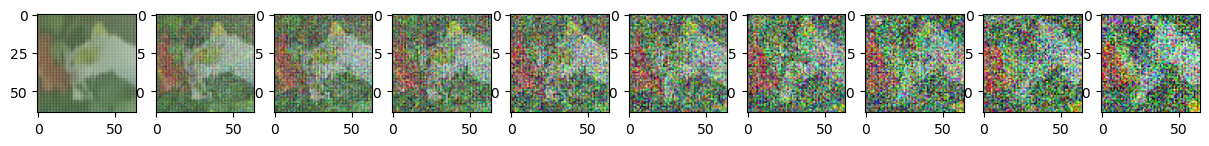

In [25]:
from torch.optim import Adam
from tqdm import tqdm_notebook

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 201

for epoch in tqdm_notebook(range(epochs)):
    for step, batch in enumerate(dataloader):
          optimizer.zero_grad()

          t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,), device = device).long()
          loss = get_loss(model, batch['images'], t)
          loss.backward()
          optimizer.step()

          if epoch % 40 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()

# Финальные выводы

Удалось обучить довольно простую диффузиоонцю модель генерировать некое подобие цветов, что уже не плохо.

В части 1.2 посмотрю, как справится полноценная Unet с помощью API с Hugging Face.